In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [2]:
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Now download our dataset, on BBC news, we'll classify the documents

In [3]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

File 'bbc_text_cls.csv' already there; not retrieving.



In [4]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

#text column contains the documents, labels contain theme

text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business

In [5]:
len(df)

2225

In [6]:
## assign the columns to 2 variables
inputs = df['text']
labels = df['labels']

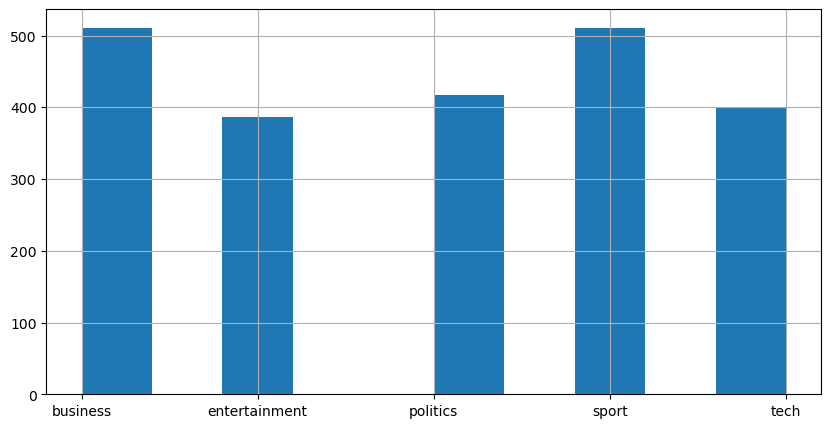

In [7]:
#build hist to see whether or not we have imbalanced clases, this can be an issue when checking the accuracy 
#if one class over or underrepresented
# ex: if 99% of data belong to 1 class, we'll have 99% of accuracy but that means only by predicting that class
labels.hist(figsize=(10, 5));

In [8]:
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(
    inputs, labels, random_state=123)
vectorizer = CountVectorizer()

Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

In [9]:
Xtrain #1668x26287

#it's a sparse matrix, bcz most values are a zero, a more effcient representation

#also see the size of matrix
#this particular case typically very undesirable in ML
#we wanna have much more rows tahn columns

<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

In [10]:
# what percentage of values are non-zero?
(Xtrain != 0).sum() / np.prod(Xtrain.shape)

#Xtrain.shape is a tuple that shows number of rows and columns, prod calculates the inner product yani onları çarpar


0.007695239935415004

In [11]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9922062350119905
test score: 0.9712746858168761


In [22]:
## with stopwords

vectorizer = CountVectorizer(stop_words = "english")
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

#slightly improved score

train score: 0.9928057553956835
test score: 0.9766606822262118


In [23]:
Xtrain #<1668x25995

<1668x25995 sparse matrix of type '<class 'numpy.int64'>'
	with 242123 stored elements in Compressed Sparse Row format>

In [13]:
### now let's use lemmatization for tokens

def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [14]:
# define a class called lemma tokenizer
#this class will perform all lemmatization and tokenization by own

#first start by creating an instance of worldnet lemmatizer object
#then call taht object as if it were a function , takes one argument, the doc to tokenize

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc) #this converts doc to tokens, like a fancier version of string split
    words_and_tags = nltk.pos_tag(tokens) #this obtains pos tags, returns a tuple
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]


In [24]:
## next try our lemma tokenizer with countvectorizer

vectorizer = CountVectorizer(tokenizer= LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9922062350119905
test score: 0.9676840215439856


In [25]:
Xtrain

<1668x26000 sparse matrix of type '<class 'numpy.int64'>'
	with 327738 stored elements in Compressed Sparse Row format>

In [16]:
### now try with stemmer:

class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def call(self,doc):
        tokens = word_tokenize(doc)
        return(self.porter.stem(t) for t in tokens)

In [18]:
vectorizer = CountVectorizer(tokenizer= StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

TypeError: 'StemTokenizer' object is not callable

TypeError: 'StemTokenizer' object is not callable

Çünkü salak gibi call functionı başına sonuna tireyle yazmayı unutmuşum, __call__

In [19]:
### now try with stemmer:

class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self,doc):
        tokens = word_tokenize(doc)
        return(self.porter.stem(t) for t in tokens)

In [26]:
vectorizer = CountVectorizer(tokenizer= StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9892086330935251
test score: 0.9694793536804309


In [29]:
Xtrain

<1668x52144 sparse matrix of type '<class 'numpy.int64'>'
	with 369097 stored elements in Compressed Sparse Row format>

Test score slightly better than the lemma tokenizer but still not as good as the first two, default countvectorizer with and w/o stopwords

special tokenization did not improve the model

In [28]:
#let's try with simplest possible tokenizer:
def simple_tokenizer(s):
    return s.split()

vectorizer = CountVectorizer(tokenizer= simple_tokenizer) #burda sonunda parentez yok çünkü bu bi fonksyion class değil
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9952038369304557
test score: 0.9712746858168761


In [ ]:
Xtrain

#test score: 0.9712746858168761 was the test score for the first model, it's exactly the same
default argument of count vectorizer is same ?? 

On the other hand, train score has improved. simple split is a good choice.
CV default parametrede kendisi de aynı şeyi yapıyo mu yapmıyo mu

### Final exercise: Print out the size of Xtrain in each case

vector dimensionality in each case

what you should find is that there are large differences in each case
compare them and consider why they are larger and smaller

- first case :#1668 x 26287
- second case (stopwords): #<1668 x 25995
- third case (lemma):#1668 x 26000
- fourth case(stem):#1668 x 22828
- fifth case(simple):#1668 x 52144
    
So the sparse matrices have 1668 rows in each case, which is normal, rows show the number of documents.

Yet, large differences for columns, i.e. number of words after the tokenization. Yani inş kolon bunu gösteriyodur.

It's intiutive that when you remove stopwords, you get a lower number of tokens compared to the first.

Lemmatization generates a nearly equal number to the countvectorizer, a bit less. maybe becaue words like walk and walking treated differently in the first one but same in the lemmatizer. Actually I'd expect differences to be bigger.

Stemming yields much lower number of words, interesting, hani mice ve mouse iki ayrı kelimeydi stemmingde, lemma'nın daha küçük olmasını beklerdim

Simple, acaba bu aksanlı ve azıcık farklı yazılmış her kelimeye farklı kelime muamelesi yaptı diye mi bu kadar yüksek, count vectorizer otomatik olarak bu aksanları eliyo muydu?

#### Recall that the default method lowercases the letters (less tokens), removes punctuation (less tokens), takes only tokens with 2 or more characters (less tokens) and so on.